In [1]:
import pandas as pd
import numpy as np
import datetime
import json
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from water_properties import density, viscosity, conductivity, heat_capacity

In [2]:
# Parametros utilizados no artigo para a Conferencia
Rg = 8.31 # * J / (K * mol)) # Gas universal constant
cH = 29.5 # #CO2 Henry constant
k1 = 4.47e-7 # Calcium carbonate first order dissociation constant
k2 = 4.68e-11 # Calcium carbonate second order dissociation constant
ksp =4.9e-9 # Calcium solubility product
kf = 2.19 # * (W ** (1)) * (m ** (-1)) * (K ** (-1))) # Film thermal conductivity
rhof = 2.71e3 # (kg ** (1)) * (m ** (-3))) # Film density
psi = 0.01 #  # Deposition strength factor

### Relação Entre Alcalinidade, pH, Ca2+ e taxa de depósito

In [3]:
with open("colesoncove_cs.out.json") as f:
    json_data=f.read()
output = json.loads(json_data)

In [4]:
P = np.mean(np.array(output["condenser.P"]["Values"][0]))
T = np.mean(np.array(output["condenser.T"]["Values"][0]))
v = np.mean(np.array(output["condenser.v"]["Values"][0]))
D = np.mean(np.array(output["condenser.D"]["Values"][0]))

rho = density( T, P, simplified = True)
mu = viscosity( T, P, simplified = True)
Re = D * v * rho / mu
kr = np.exp(38.74 - 20700.0 / (1.987 * T))
Dab = 3.07e-15 * (T / mu)
Sc = mu / (rho * Dab)
kd = 0.023 * v * Re ** -0.17 * Sc ** -0.67

def calculate_CO3(pH, Alc):
    k2 = 4.68e-11 # Calcium carbonate second order dissociation constant
    conc_H = 10 ** (-pH)    
    conc_CO3 = k2*Alc/1000/(100.0869 * (conc_H + 2*k2))
    return conc_CO3
    
def calculate(pH, Ca, Alc):
    
    conc_Ca = Ca/1000/40.078
    
    conc_CO3 = calculate_CO3(pH, Alc)
    
    removal_fraction = 0.00212*v**2/(kf ** 0.5 * psi)
    
    phid = kd*conc_CO3*(1-ksp/(conc_Ca*conc_CO3))/(1+kd/(kr*conc_CO3)+conc_CO3/conc_Ca)
    phir = phid*removal_fraction
    
    return phid*(1 - 0.00212 * v**2/(kf ** 0.5 * psi))

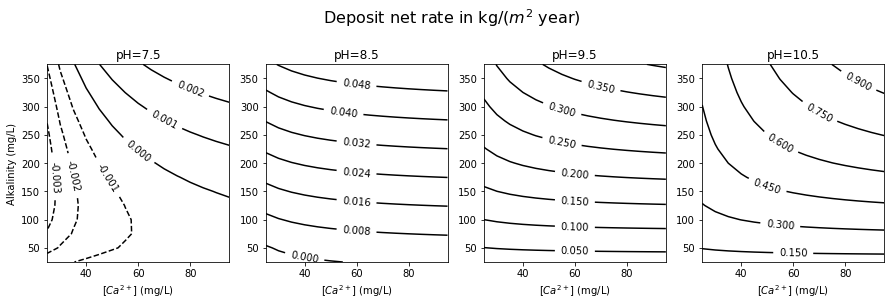

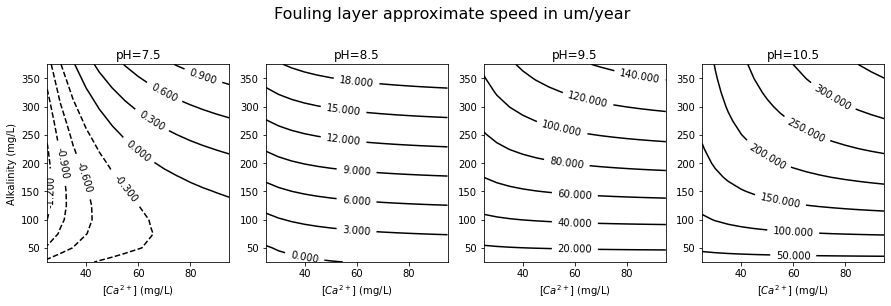

For temperature 294.1833504848364 K, pressure 185510.57807654003 Pa, velocity 1.3982154297020155 m/s and diameter 0.022899261980727517 m


In [5]:
# Make data
x = np.arange(25, 100, 5)
y = np.arange(25, 400, 25)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(15, 8))

pHs = (7.5, 8.5, 9.5, 10.5)

for k, pH in  enumerate(pHs):

    ax = fig.add_subplot(2, 4, k+1)

    Z = np.ones(X.shape)
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            zij = calculate(pH, xi, yj)*365*24*3600
            Z[j,i] = zij

    CS = ax.contour(X, Y, Z, colors = 'k')
    ax.clabel(CS, inline=1, fontsize=10)
    ax.set_title('pH={}'.format(pH))
    ax.set_xlabel('$[Ca^{2+}]$ (mg/L)')
    if k == 0:
        ax.set_ylabel('Alkalinity (mg/L)')
    
fig.suptitle('Deposit net rate in kg/($m^2$ year)', fontsize=16)
plt.show()


fig = plt.figure(figsize=(15, 8))

for k, pH in  enumerate(pHs):

    ax = fig.add_subplot(2, 4, k+1)

    Z = np.ones(X.shape)
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            zij = calculate(pH, xi, yj)*365*24*3600/rhof*1e6
            Z[j,i] = zij

    CS = ax.contour(X, Y, Z, colors = 'k')
    ax.clabel(CS, inline=1, fontsize=10)
    ax.set_title('pH={}'.format(pH))
    ax.set_xlabel('$[Ca^{2+}]$ (mg/L)')
    if k == 0:
        ax.set_ylabel('Alkalinity (mg/L)')
    
fig.suptitle('Fouling layer approximate speed in um/year', fontsize=16)
plt.savefig('./figures/fouling_contours.pdf', dpi=600)
plt.show()
print("For temperature {} K, pressure {} Pa, velocity {} m/s and diameter {} m".format(T,P,v,D))

## Rio Tejo - Série histórica

Vejam a seguir os dados históricos para o rio Tejo em Santarém.

In [6]:
# https://gemstat.bafg.de/applications/public.html?publicuser=PublicUser
df = pd.read_csv("/Users/jaimenms/WorkingFolder/carbonatedeposit-condenser/notebooks/tejo_data.csv", sep="\t").dropna()
df["dt"]=np.array([ datetime.datetime.strptime(val, '%d/%m/%Y %H:%M') for val in df["dt"].values])
df = df.set_index('dt')
df["[H+]"] = 10 ** (-df["pH"])
df["[Ca2+]"] = df["Ca"]/1000/40.078
df["[CO3_2-]"] = k2*df["Alc"]/1000/(100.0869 * (df["[H+]"] + 2*k2))
df["[HCO3_-]"] = df["Alc"]*df["[H+]"]/1000/(100.0869 * (df["[H+]"] + 2*k2))
df["[CO2]"] = df["Alc"]*df["[H+]"]**2/1000/(100.0869 * k1 * (df["[H+]"] + 2*k2))
df["phid"] = kd * df["[CO3_2-]"] * (1 - ksp / (df["[Ca2+]"] * df["[CO3_2-]"])) / (1 + kd / (kr * df["[CO3_2-]"]) + df["[CO3_2-]"] / df["[Ca2+]"])
df["Alc_calc"] = 2* df["[CO3_2-]"] + df["[HCO3_-]"]*1000*100.078
df["pCO2"] = df["[CO2]"] * cH
df

,pH,Ca,Alc,[H+],[Ca2+],[CO3_2-],[HCO3_-],[CO2],phid,Alc_calc,pCO2
dt,,,,,,,,,,,
1989-05-09 10:45:00,7.8,130.40,67.6,1.584893e-08,0.003254,1.982705e-06,0.000671,0.000024,1.246566e-11,67.197143,0.000702
1989-06-06 10:00:00,7.2,25.90,60.5,6.309573e-08,0.000646,4.476929e-07,0.000604,0.000085,-7.114391e-11,60.405013,0.002513
1989-07-04 11:30:00,7.3,44.90,35.0,5.011872e-08,0.001120,3.259315e-07,0.000349,0.000039,-3.108614e-11,34.931651,0.001155
1989-08-22 11:30:00,7.7,11.24,45.6,1.995262e-08,0.000280,1.063655e-06,0.000453,0.000020,-3.041897e-10,45.383050,0.000597
1989-10-17 10:30:00,6.9,112.40,69.1,1.258925e-07,0.002805,2.564625e-07,0.000690,0.000194,-9.315457e-12,69.042523,0.005732
1989-11-14 10:30:00,7.6,73.10,49.7,2.511886e-08,0.001824,9.217427e-07,0.000495,0.000028,-2.987697e-11,49.511090,0.000820
1990-01-09 11:30:00,7.2,98.30,50.2,6.309573e-08,0.002453,3.714741e-07,0.000501,0.000071,-1.393393e-11,50.121184,0.002085
1990-02-06 11:40:00,7.9,120.00,36.0,1.258925e-08,0.002994,1.327254e-06,0.000357,0.000010,-6.555813e-12,35.731144,0.000297
1990-05-08 10:45:00,6.9,10.00,23.3,1.258925e-07,0.000250,8.647723e-08,0.000233,0.000066,-4.494598e-11,23.280619,0.001933


## Com parâmetros usados na conferência

Esses são os dados utilizados no artigo da conferência. Vejam que a dureza está com um valor compatível com um rio, mas a alcalinidade está muito alta.

In [7]:
# Parametros utilizados no artigo para a Conferencia
conc_H = 10 ** (-9.55) #Concentration of Hydrogen cation
conc_Ca = 0.0037/3 # #Calcium concentration (molar)  49,4 mg/L Ca2+  --> x2.5 = hardness 123.5 mg/L CaCO3
pCO2 = 0.0314 / 100 #CO2 partial pressure

conc_CO2= pCO2 / cH
conc_HCO3 = (conc_CO2 * k1) / conc_H
conc_CO3 = (conc_HCO3 * k2) / conc_H 

Alc = (2*conc_CO3 + conc_HCO3)*100.09*1000 # mg/L CaCO3
pH = -np.log10(conc_H)
conc_mass_Ca2 = conc_Ca*40.078*1000

print("Alcalinity is {} mg/L CaCO3".format(Alc)) # MUITO ALTA!!!
print("pH is {}".format(pH))
print("Ca2+ is {} mg/L".format(conc_mass_Ca2))

Alcalinity is 2250.8388948902248 mg/L CaCO3
pH is 9.55
Ca2+ is 49.429533333333346 mg/L


Calculando algumas variáveis do fouling usando os dados médios do Colesoncove

In [8]:
T = 300

rho = density( T, P, simplified = True)
mu = viscosity( T, P, simplified = True)
Re = D * v * rho / mu
kr = np.exp(38.74 - 20700.0 / (1.987 * T))
Dab = 3.07e-15 * (T / mu)
Sc = mu / (rho * Dab)
kd = 0.023 * v * Re ** -0.17 * Sc ** -0.67

phid = kd * conc_CO3 * (1 - ksp / (conc_Ca * conc_CO3)) / (1 + kd / (kr * conc_CO3) + conc_CO3 / conc_Ca)
phir = phid*0.00212*v**2/(kf ** 0.5 * psi)

print("Deposit net rate is {} kg/m2s".format(phid-phir))
print("Deposit net rate is {} kg/m2year".format((phid-phir)*365*24*3600))
print("Approximate speed is {} um/year".format((phid-phir)*365*24*3600/rhof*1e6))
print("Approximate Resistance is {} (K/W)/year".format((1/kf)*(phid-phir)*365*24*3600/rhof))

Deposit net rate is 3.620379867703185e-08 kg/m2s
Deposit net rate is 1.1417229950788765 kg/m2year
Approximate speed is 421.29999818408726 um/year
Approximate Resistance is 0.00019237442839456037 (K/W)/year


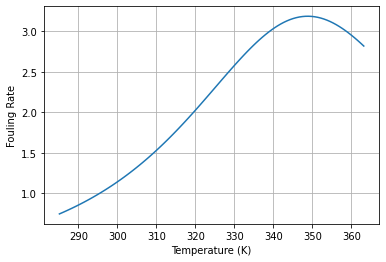

In [9]:
T_list = np.linspace(273.15+12, 273.15+90, 100)
rate_list = []
for T in T_list:
    rho = density( T, P, simplified = True)
    mu = viscosity( T, P, simplified = True)
    Re = D * v * rho / mu
    kr = np.exp(38.74 - 20700.0 / (1.987 * T))
    Dab = 3.07e-15 * (T / mu)
    Sc = mu / (rho * Dab)
    kd = 0.023 * v * Re ** -0.17 * Sc ** -0.67

    phid = kd * conc_CO3 * (1 - ksp / (conc_Ca * conc_CO3)) / (1 + kd / (kr * conc_CO3) + conc_CO3 / conc_Ca)
    phir = phid*0.00212*v**2/(kf ** 0.5 * psi)
    
    rate_list.append((phid - phir)*365*24*3600)

fig, ax = plt.subplots()
ax.plot(T_list, rate_list)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Fouling Rate")
ax.grid()
plt.show()

## Com parâmetros propostos

Novos parâmetros Propostos

In [12]:
conc_H = 10 ** (-10.5) #Concentration of Hydrogen cation
conc_Ca = 0.0012 # #Calcium concentration (molar)  49,4 mg/L Ca2+  --> x2.5 = hardness 123.5 mg/L CaCO3
pCO2 = 0.00003 #CO2 partial pressure (ATM)

Alc = 300
Ca = 49.42
conc_Ca = Ca/1000/40.078
conc_CO3 = calculate_CO3(pH, Alc)
conc_HCO3 = conc_CO3*conc_H/k2

pH = -np.log10(conc_H)


print("Alcalinity is {} mg/L CaCO3".format(Alc)) # MUITO ALTA!!!
print("pH is {}".format(pH))
print("Ca2+ is {} mg/L".format(Ca))
print("conc_Ca is {} mol/L".format(conc_Ca))
print("conc_CO3 is {} mol/L".format(conc_CO3))
print("conc_HCO3 is {} mol/L".format(conc_HCO3))

Alcalinity is 300 mg/L CaCO3
pH is 10.5
Ca2+ is 49.42 mg/L
conc_Ca is 0.001233095463845501 mol/L
conc_CO3 is 0.0011202283014275758 mol/L
conc_HCO3 is 0.0007569386606608531 mol/L


In [14]:
T = 300

rho = density( T, P, simplified = True)
mu = viscosity( T, P, simplified = True)
Re = D * v * rho / mu
kr = np.exp(38.74 - 20700.0 / (1.987 * T))
Dab = 3.07e-15 * (T / mu)
Sc = mu / (rho * Dab)
kd = 0.023 * v * Re ** -0.17 * Sc ** -0.67

phid = kd * conc_CO3 * (1 - ksp / (conc_Ca * conc_CO3)) / (1 + kd / (kr * conc_CO3) + conc_CO3 / conc_Ca)
phir = phid*0.00212*v**2/(kf ** 0.5 * psi)

print("phid",phid)
print("phir",phir)


print("Deposit net rate is {} kg/m2s".format(phid-phir))
print("Deposit net rate is {} kg/m2year".format((phid-phir)*365*24*3600))
print("Approximate speed is {} um/year".format((phid-phir)*365*24*3600/rhof*1e6))
print("Approximate Resistance is {} (K/W)/year".format((1/kf)*(phid-phir)*365*24*3600/rhof))

phid 3.4376590270135806e-08
phir 9.627749502468669e-09
Deposit net rate is 2.474884076766714e-08 kg/m2s
Deposit net rate is 0.7804794424491508 kg/m2year
Approximate speed is 287.99979426167926 um/year
Approximate Resistance is 0.00013150675537062983 (K/W)/year


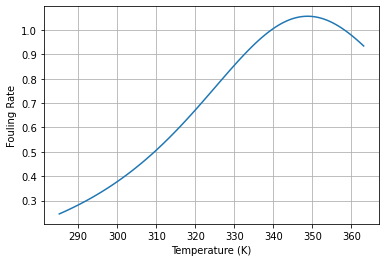

In [25]:
T_list = np.linspace(273.15+12, 273.15+90, 100)
rate_list = []
for T in T_list:
    rho = density( T, P, simplified = True)
    mu = viscosity( T, P, simplified = True)
    Re = D * v * rho / mu
    kr = np.exp(38.74 - 20700.0 / (1.987 * T))
    Dab = 3.07e-15 * (T / mu)
    Sc = mu / (rho * Dab)
    kd = 0.023 * v * Re ** -0.17 * Sc ** -0.67

    phid = kd * conc_CO3 * (1 - ksp / (conc_Ca * conc_CO3)) / (1 + kd / (kr * conc_CO3) + conc_CO3 / conc_Ca)
    phir = phid*0.00212*v**2/(kf ** 0.5 * psi)
    
    rate_list.append((phid - phir)*365*24*3600)

fig, ax = plt.subplots()
ax.plot(T_list, rate_list)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Fouling Rate")
ax.grid()
plt.show()